# EE219 Project 2

Team members:  
Yichen Wu 504294181  
Siyuan Chen 405024391

## Required Packages:
nltk v3.2.5  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy 1.0.0  
matplotlib v2.1.2  

In [1]:
import string
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, TruncatedSVD, PCA
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import *
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import *

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

'''
try:
    nltk.download("stopwords")  # if the host does not have the package
except (RuntimeError):
    pass
'''

# globals
MIN_DF = 3


class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self


tfidf_transformer = TfidfTransformer(smooth_idf=False)


def doTFIDF(data, mindf):
    vectorizer = CountVectorizer(min_df=mindf, stop_words=ENGLISH_STOP_WORDS)
    m = vectorizer.fit_transform(data)
    m_train_tfidf = tfidf_transformer.fit_transform(m)
    return m_train_tfidf


def cluster_kmean(data, n):
    km = KMeans(n_clusters=n, max_iter=100, verbose=False, random_state=42).fit(data)
    pred = km.predict(data)
    return pred


def test_stem_count_vectorize():
    test_string = ["Hello, Google. But I can't answer this call go going goes bowl bowls bowled!"]
    vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)
    X = vectorizer.fit_transform(test_string)
    feature_name = vectorizer.get_feature_names()
    print(feature_name)
    print(X.toarray())


def report_stats(label, predict, classes, display=True, msg=None):
    n = len(classes)
    cmatrix = contingency_matrix(label, predict)
    if display:
        plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.BuGn)
        plt.title("Contingency Table")
        tick_marks = np.arange(n)
        className = []
        for i in range(n):
            className.append(str(i))
        plt.xticks(tick_marks, className)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cmatrix.max() / 2.
        for i, j in itertools.product(range(n), range(n)):
            plt.text(j, i, format(cmatrix[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cmatrix[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('Ground Truth Label')
        plt.xlabel('Cluster Label')
        plt.show()

    homogeneity = homogeneity_score(label, predict)
    completeness = completeness_score(label, predict)
    v_measure = v_measure_score(label, predict)
    adjusted_Rand_Index = adjusted_rand_score(label, predict)
    adjusted_Mutual_Info_Score = adjusted_mutual_info_score(label, predict)

    if isinstance(msg, str):
        print(msg)
    print("Homogeneity: %0.3f" % homogeneity)
    print("Completeness: %0.3f" % completeness)
    print("V-measure: %0.3f" % v_measure)
    print("Adjusted Rand-Index: %.3f" % adjusted_Rand_Index)
    print("Adjusted Mutual Info Score: %0.3f" % adjusted_Mutual_Info_Score)

    return [cmatrix, [homogeneity, completeness, v_measure, adjusted_Rand_Index, adjusted_Mutual_Info_Score]]


def analyze(label, prob, predict, classes, n):
    if n <= 2:
        fpr, tpr, thresholds = roc_curve(label, prob)
        roc_auc = auc(fpr,tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='lightsteelblue',
                 lw=2, label='AUC (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='deeppink', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

    cmatrix = confusion_matrix(label, predict)
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.BuGn)
    plt.title("Confusion Matrix")
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(n), range(n)):
        plt.text(j, i, format(cmatrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if cmatrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    print("accuracy: ", accuracy_score(label, predict))
    if n <= 2:
        print("recall: ", recall_score(label, predict))
        print("precision: ", precision_score(label, predict))
    else:
        print("recall: ", recall_score(label, predict, average='weighted'))
        print("precision: ", precision_score(label, predict, average='weighted'))
    return




This part is to load data and import the library that we need for this project.

In [2]:
import numpy as np
import logging
import os
import pickle
from logging.config import fileConfig
from sklearn.datasets import fetch_20newsgroups

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

cat_comp = categories[:4]   # Computer Technologies
cat_rec = categories[4:]    # Recreational Activities
CAT = ["Computer Technologies", "Recreational Activities"]

logging.info("loading data")
# all_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# create labels
# 0 for computer technology, 1 for recreational activities
# all_label = [(x//4) for x in all_data.target]
train_label = [(x//4) for x in train_data.target]
test_label = [(x//4) for x in test_data.target]

logging.info("loading finished")



#### a)

In [4]:
from timeit import default_timer as timer

GET_DATA_FROM_FILES = True

logging.info("Problem 1")
start = timer()

X_train_tfidf = None
if GET_DATA_FROM_FILES and os.path.isfile("./train_tfidf.pkl"):
    logging.info("Loading tfidf vector.")
    X_train_tfidf = pickle.load(open("./train_tfidf.pkl", "rb"))
else:
    X_train_tfidf = doTFIDF(train_data.data, MIN_DF)
    pickle.dump(X_train_tfidf, open("./train_tfidf.pkl", "wb"))

print("With min_df = %d , (training documents, terms extracted): " % MIN_DF, X_train_tfidf.shape)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 1")


With min_df = 3 , (training documents, terms extracted):  (4732, 20297)


#### b)

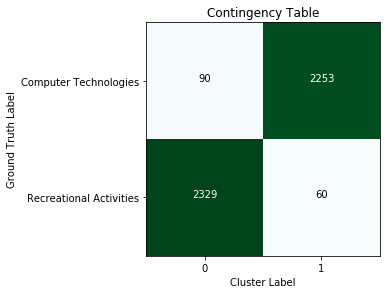

Homogeneity: 0.798
Completeness: 0.798
V-measure: 0.798
Adjusted Rand-Index: 0.877
Adjusted Mutual Info Score: 0.798


In [5]:

logging.info("Problem 2")
start = timer()

km_pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./kmean.pkl"):
    logging.info("Loading predicted kmean.")
    km_pred = pickle.load(open("./kmean.pkl", "rb"))
else:
    km_pred = cluster_kmean(X_train_tfidf, 2)
    pickle.dump(km_pred, open("./kmean.pkl", "wb"))

report_stats(train_label, km_pred, CAT)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 2")

#### c) - 1

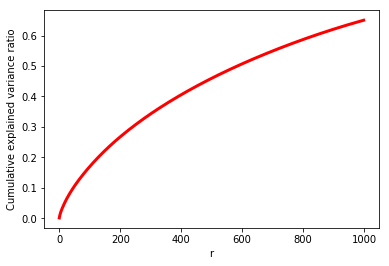

In [6]:

logging.info("Problem 3")
start = timer()

R_MAX = 1000
ratio = None
if GET_DATA_FROM_FILES and os.path.isfile("./ratio.pkl"):
    logging.info("Loading ratio.")
    ratio = pickle.load(open("./ratio.pkl", "rb"))
else:
    svd = TruncatedSVD(n_components=R_MAX, n_iter=7, random_state=42)
    svd.fit_transform(X_train_tfidf)
    ratio = svd.explained_variance_ratio_.cumsum()
    pickle.dump(ratio, open("./ratio.pkl", "wb"), True)

plt.plot(range(R_MAX), ratio, 'r', lw=3, label='Cumulative explained variance ratio')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('r')
plt.show()


#### c) - 2

With r = 1 Using LSI
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.000
Adjusted Mutual Info Score: -0.000
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[1292 1051]
 [1343 1046]]
------------------------------
With r = 2 Using LSI
Homogeneity: 0.515
Completeness: 0.530
V-measure: 0.523
Adjusted Rand-Index: 0.568
Adjusted Mutual Info Score: 0.515
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[  45 2298]
 [1851  538]]
------------------------------
With r = 3 Using LSI
Homogeneity: 0.262
Completeness: 0.338
V-measure: 0.295
Adjusted Rand-Index: 0.194
Adjusted Mutual Info Score: 0.261
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[   5 2338]
 [1071 1318]]
------------------------------
With r = 5 Using LSI
Homogeneity: 0.225
Completeness: 0.314
V-measure: 0.263
Adjusted Rand-Index: 0.148
Adjusted Mutual Info Score: 0.225
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[   2 2341]
 [ 935 1454]]
---------

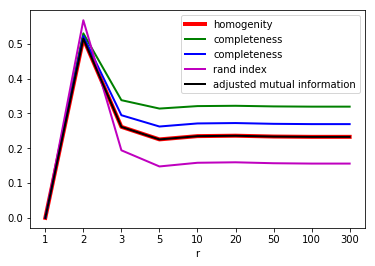

************************************************************
The best R value for TruncatedSVD is 2
The contingency matrix is: 
[[  45 2298]
 [1851  538]]
Homogeneity: 0.515
Completeness: 0.530
V-measure: 0.523
Adjusted Rand-Index: 0.568
Adjusted Mutual Info Score: 0.515
************************************************************


In [10]:
# LSI
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

y = []
cmatrix = []
for i in r:
    svd = TruncatedSVD(n_components=i, random_state=42)
    # normalizer = Normalizer(copy=False)
    # pipeline = make_pipeline(svd, normalizer)
    # X_train_lsi = pipeline.fit_transform(X_train_tfidf)
    X_train_lsi = svd.fit_transform(X_train_tfidf)
    kmean = cluster_kmean(X_train_lsi, 2)
    msg = 'With r = %d' % i + " Using LSI"
    result = report_stats(train_label, kmean, CAT, display=False, msg=msg)
    print("-  "*10)
    print("The contingency matrix is: ")
    cmatrix.append(result[0])
    print(result[0])
    y.append(result[1])
    print("-"*30)

y_transpose = np.array(y).T.tolist()

r_len = len(r)
l1, = plt.plot(range(r_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r_len)
labels = [str(a) for a in r]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi = np.bincount(best_r).argmax() # best_r_index
print("The best R value for TruncatedSVD is %d" % r[bi])
print("The contingency matrix is: ")
print(cmatrix[bi])
print("Homogeneity: %0.3f" % y_transpose[0][bi])
print("Completeness: %0.3f" % y_transpose[1][bi])
print("V-measure: %0.3f" % y_transpose[2][bi])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi])
print("*"*60)

#### c) - 3

With r = 1 Using NMF
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.000
Adjusted Mutual Info Score: -0.000
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[1292 1051]
 [1343 1046]]
------------------------------
With r = 2 Using NMF
Homogeneity: 0.691
Completeness: 0.691
V-measure: 0.691
Adjusted Rand-Index: 0.790
Adjusted Mutual Info Score: 0.691
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[ 119 2224]
 [2245  144]]
------------------------------
With r = 3 Using NMF
Homogeneity: 0.231
Completeness: 0.320
V-measure: 0.269
Adjusted Rand-Index: 0.153
Adjusted Mutual Info Score: 0.231
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[   1 2342]
 [ 949 1440]]
------------------------------
With r = 5 Using NMF
Homogeneity: 0.175
Completeness: 0.276
V-measure: 0.214
Adjusted Rand-Index: 0.095
Adjusted Mutual Info Score: 0.175
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[   2 2341]
 [ 756 1633]]
---------

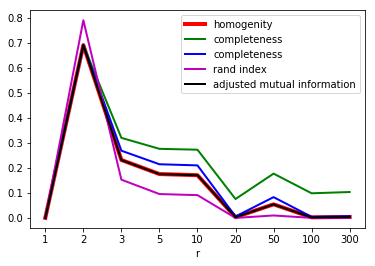

************************************************************
The best R value for NMF is 2
The contingency matrix is: 
[[ 119 2224]
 [2245  144]]
Homogeneity: 0.691
Completeness: 0.691
V-measure: 0.691
Adjusted Rand-Index: 0.790
Adjusted Mutual Info Score: 0.691
************************************************************


In [9]:
# NMF
y = []
cmatrix = []
for i in r:
    svd = NMF(n_components=i)
    # normalizer = Normalizer(copy=False)
    # pipeline = make_pipeline(svd, normalizer)
    # X_train_lsi = pipeline.fit_transform(X_train_tfidf)
    X_train_nmf = svd.fit_transform(X_train_tfidf)
    kmean = cluster_kmean(X_train_nmf, 2)
    msg = 'With r = %d' % i + " Using NMF"
    result = report_stats(train_label, kmean, CAT, display=False, msg=msg)
    print("-  "*10)
    print("The contingency matrix is: ")
    cmatrix.append(result[0])
    print(result[0])
    y.append(result[1])
    print("-"*30)

y_transpose = np.array(y).T.tolist()

r_len = len(r)
l1, = plt.plot(range(r_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r_len)
labels = [str(a) for a in r]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi = np.bincount(best_r).argmax() # best_r_index
print("The best R value for NMF is %d" % r[bi])
print("The contingency matrix is: ")
print(cmatrix[bi])
print("Homogeneity: %0.3f" % y_transpose[0][bi])
print("Completeness: %0.3f" % y_transpose[1][bi])
print("V-measure: %0.3f" % y_transpose[2][bi])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi])
print("*"*60)